In [1]:
SEED_EXPERIMENT=0

In [2]:
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from models.utils import save_model

import pytorch_lightning as pl

from transforms.transform import base_transform, augmented_transform, IdentityTransform, simsiam_representation_transform

from models.encoders import get_resnet18_encoder, get_shufflenetv2_encoder, get_alexnet_encoder, SpectrumCNN

from models.lit_models import CNN_classifier, SimSiam
import os
import random


os.environ['PYTHONHASHSEED'] = str(SEED_EXPERIMENT)
# Torch RNG
torch.manual_seed(SEED_EXPERIMENT)
torch.cuda.manual_seed(SEED_EXPERIMENT)
torch.cuda.manual_seed_all(SEED_EXPERIMENT)
# Python RNG
np.random.seed(SEED_EXPERIMENT)
random.seed(SEED_EXPERIMENT)

batch_size = 64

# 1. Choose the dataset!

In [3]:
DATASET_NAME = "AMP_PHASE"
train_dataset_amp_phase = torchvision.datasets.ImageFolder('data/images_amp_phase/train', transform=base_transform)
train_dataloader = DataLoader(train_dataset_amp_phase, shuffle=True, batch_size=batch_size, num_workers=1)

In [3]:
DATASET_NAME = "SPECTROGRAM"
train_dataset_spectrogram = torchvision.datasets.ImageFolder('data/images_spectrogram/train', transform=base_transform)
train_dataloader = DataLoader(train_dataset_spectrogram, shuffle=True, batch_size=batch_size, num_workers=1)

# 2.Choose the model!

In [3]:
MODEL_NAME="RESNET_18"
encoder = get_resnet18_encoder()

In [4]:
MODEL_NAME="SHUFFLENET"
encoder = get_shufflenetv2_encoder()

In [4]:
MODEL_NAME="ALEXNET"
encoder = get_alexnet_encoder()

In [4]:
MODEL_NAME="SPECTRUM_CNN"
encoder=SpectrumCNN()

# 3. Run everything below!

In [5]:
transform = simsiam_representation_transform
lit_model = SimSiam(encoder=encoder, transforms=transform)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:59: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=50)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr:   3%|▎         | 3/100 [00:00<00:08, 11.27it/s]
LR finder stopped early after 

None


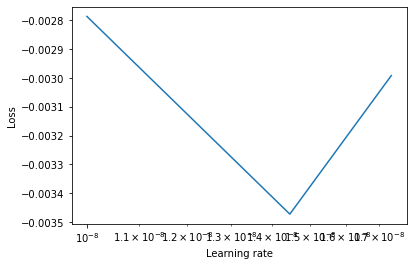

In [6]:
pretrainer = pl.Trainer(
    auto_lr_find=True,
    gpus=1, max_epochs=10,
    enable_checkpointing=True,
    log_every_n_steps=10,
    flush_logs_every_n_steps=50
)
# Run learning rate finder
lr_finder = pretrainer.tuner.lr_find(lit_model, train_dataloaders=train_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
print(lr_finder.suggestion())

In [7]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
if new_lr is None:
    new_lr = 1e-3

# update hparams of the model
lit_model.hparams.lr = new_lr

# # Fit model
pretrainer.fit(lit_model, train_dataloaders=train_dataloader)

Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/tuner/lr_finder.py", line 176, in suggestion
    min_grad = np.gradient(loss).argmin()
  File "<__array_function__ internals>", line 5, in gradient
  File "/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/numpy/lib/function_base.py", line 1053, in gradient
    raise ValueError(
ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | SpectrumCNN      | 5.8 M 
1 | predictor | Sequential       | 263 K 
2 | criterion | CosineSimilarity | 0     
-----------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     To

Epoch 9: 100%|██████████| 719/719 [00:36<00:00, 19.85it/s, loss=-0.997, v_num=8]


In [8]:
save_model(model=lit_model.encoder, save_path=f"pretrained_encoders/{DATASET_NAME}__{MODEL_NAME}.pth",)

('pretrained_encoders/SPECTROGRAM__SPECTRUM_CNN.pth', {})

# Learning Rate used:
- RESNET18 (0, 1): amp=2.7542287033381663e-05, spec=4.786300923226385e-05
- SHUFFLENET (2, 3): amp=failed(1e-3), spec=failed(1e-3)
- AlexNet(4, 6): amp=failed(1e-3), spec=failed(1e-3)
- SpectrumCNN(7, 8): amp=failed(1e-3), spec=failed(1e-3)